In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import loguniform
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'png' # avg is better, however GitHub cant handle it

In [2]:
df = pd.read_csv('googleplaystore.csv')

# EDA

## General Summary

In [3]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


## Missing values

In [5]:
def missing_df(df):
    perc_missing = (df.isnull().sum() * 100 / len(df)).round(2)
    missing_value_df = pd.DataFrame({'num_missing': df.isnull().sum(),
                                     'perc_missing': perc_missing})
    missing_value_df = missing_value_df[missing_value_df.num_missing != 0]
    return missing_value_df.sort_values(by='perc_missing', ascending=False)

In [6]:
missing_df(df)

,num_missing,perc_missing
Rating,1474,13.60
Current Ver,8,0.07
Android Ver,3,0.03
Type,1,0.01
Content Rating,1,0.01


## Data Cleaning

Recording to the current data, App Rating is our one and only numeric feature, which is clearly not true. Let's fix that.

In [7]:
def fix_size(row):
    if row[-1] == 'M':
        return float(row[:-1])*1000000
    elif row[-1] == 'k':
        return float(row[:-1])*1000
    else:
        return None

In [8]:
def fix_installs(row):
    if row[-1] == '+':
        return int(row[:-1].replace(',', ''))
    else:
        return int(row)

In [9]:
def fix_price(row):
    if row[0] == '$':
        return float(row[1:])
    else:
        return float(row)

In [10]:
record = df[df['Rating'] == 19] 
df.drop(record.index, inplace=True) # dropping broken record

df['Size'] = df['Size'].apply(fix_size)
df['Reviews'] = df['Reviews'].astype(int)
df['Installs'] = df['Installs'].apply(fix_installs)
df['Price'] = df['Price'].apply(fix_price)
df['Type'] = np.where(df['Type'] == 'Paid', 1, 0)

## Target Variable (Rating) distribution

In [11]:
def show_dist(df, var, bins):
    fig = plt.figure(constrained_layout=True, figsize=(10, 5))
    grid = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
    
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram of %s' % var)
    sns.distplot(df.loc[:, var], bins, norm_hist=True, ax=ax1);
    
    ax2 = fig.add_subplot(grid[0, 2])
    ax2.set_title('Box Plot of %s' % var)
    sns.boxplot(y=df.loc[:, var], ax=ax2);

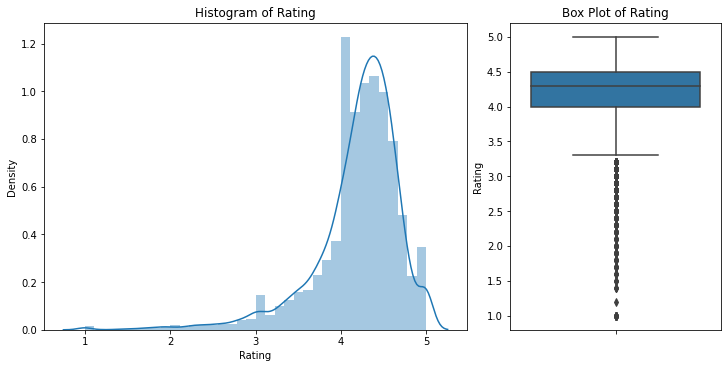

In [12]:
show_dist(df, 'Rating', 36)

In [13]:
print("Skewness: " + str(df['Rating'].skew()))
print("Kurtosis: " + str(df['Rating'].kurt()))

Skewness: -1.8496951283704521
Kurtosis: 5.7869240668056


## App Rating vs 'Other Features'


In [14]:
abs(df.corr()['Rating']).sort_values(ascending = False)[1:].to_frame('correlation')

,correlation
Size,0.083734
Reviews,0.068141
Installs,0.051355
Type,0.039581
Price,0.021903


We see that our numeric features are in very poor correlation with Rating.

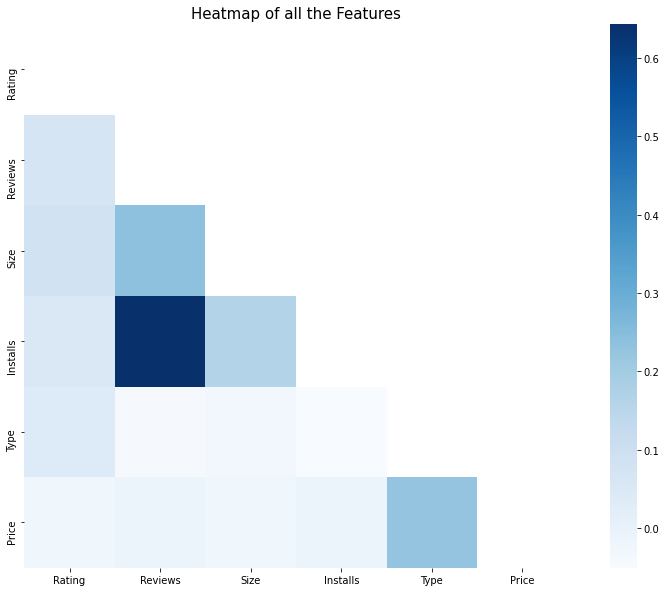

In [15]:
plt.subplots(figsize = (15, 10))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df.corr(), cmap="Blues", 
            mask = mask, square=True);
plt.title("Heatmap of all the Features", fontsize=15);

High correlation Installs-Reviews, it's quite understandable. What is also interesting, there is a lack of negatively correlated features.

## Rating vs Reviews

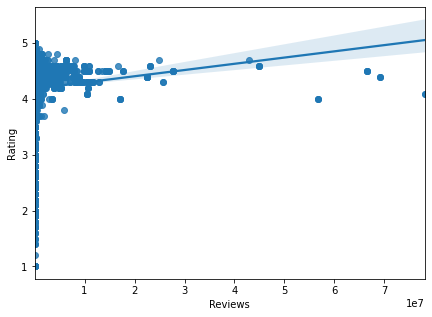

In [16]:
plt.figure(figsize=(7, 5))
sns.regplot(x=df['Reviews'], y=df['Rating']);

We can see that Reviews values are highly imbalanced, there are a lot of outliers. We are going to try to normalize it during Features Engineering.

## Rating vs Installs

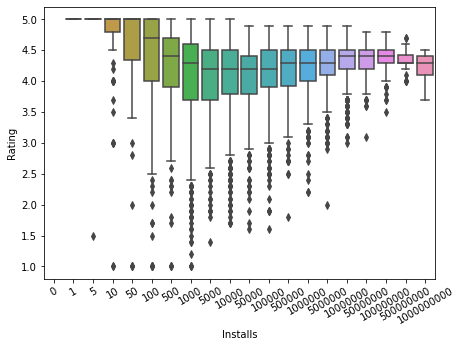

In [17]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(df['Installs'], df['Rating']);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

## Rating vs Price

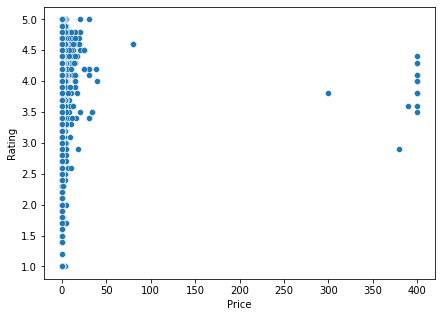

In [18]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x=df['Price'], y=df['Rating']);

Again, many outliers.

## Rating vs Type

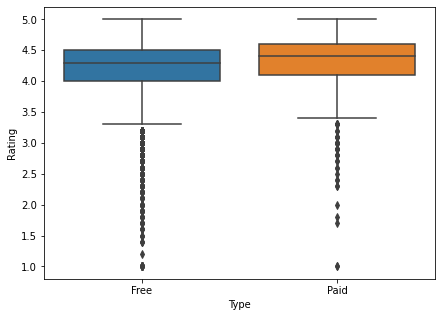

In [19]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(df['Type'], df['Rating']);
ax.set_xticklabels(['Free', 'Paid']);

## Rating vs Category

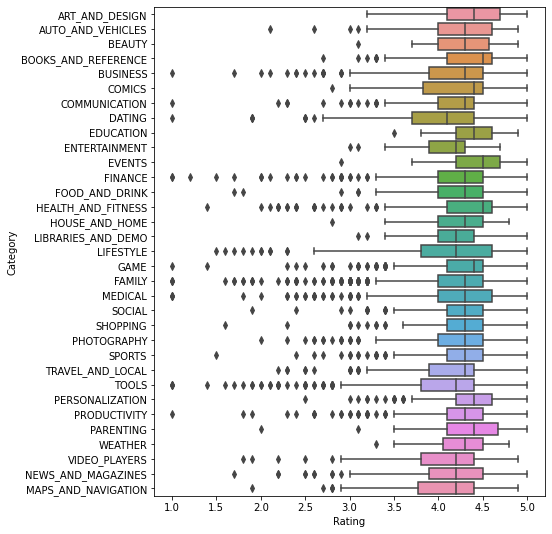

In [20]:
plt.figure(figsize=(7, 9))
ax = sns.boxplot(y = df['Category'], x = df['Rating'])

# Features Engineering

## Handling missing values

In [21]:
missing_df(df)

,num_missing,perc_missing
Size,1695,15.64
Rating,1474,13.60
Current Ver,8,0.07
Android Ver,2,0.02


In [22]:
df['Rating'] = df['Rating'].fillna(df['Rating'].median())
df['Size'] = df['Size'].fillna(method = 'ffill')
df['Current Ver'] = df['Current Ver'].fillna(method = 'ffill')
df['Android Ver'] = df['Android Ver'].fillna(method = 'ffill')

In [23]:
missing_df(df)

,num_missing,perc_missing


## Fixing Features Skewness

In [24]:
def show_skewed(df):
    num_features = df.dtypes[df.dtypes != 'object'].index.values
    num_features = num_features[num_features != 'Type']
    num_features = num_features[num_features != 'Rating']
    skew_features = df[num_features].apply(lambda x: x.skew()).sort_values(ascending=False)
    return skew_features.to_frame('Skewness')

In [25]:
skew_features = show_skewed(df)
skew_features

,Skewness
Price,23.707392
Reviews,16.449584
Installs,9.572067
Size,1.528761


In [26]:
def fix_skewness(skew_features):
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    to_fix = skew_features[abs(skew_features) > 0.6]
    for feature in to_fix.index:
        df[feature] = boxcox1p(df[feature], boxcox_normmax(df[feature] + 1))

In [27]:
fix_skewness(skew_features)

In [28]:
skew_features = show_skewed(df)
skew_features

,Skewness
Price,3.504562
Reviews,0.085492
Installs,-0.002772
Size,-0.049428


## Creating New Features

In [29]:
df['Last Updated'] = pd.to_datetime(df['Last Updated'])
df['Last_Updated_month'] = df['Last Updated'].dt.month
df['Last_Updated_year'] = df['Last Updated'].dt.year

## Deleting Some Features

In [30]:
df = df.drop(['App', 'Genres', 'Current Ver', 'Last Updated'], axis=1)

## Categorical Features Encoding

In [31]:
df = pd.get_dummies(df).reset_index(drop=True)
df.shape

(10840, 80)

# Training Model

In [32]:
X = df.drop('Rating', axis=1)
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=0)

## Fitting Models 

In [33]:
def create_models():
    ridge = Ridge(random_state=42)
    rff = RandomForestRegressor(random_state=42)
    xgb = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
    svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon= 0.01, gamma=0.001))
    knn = KNeighborsRegressor(n_neighbors=15)
    
    return [ridge, rff, xgb, svr, knn]

In [34]:
def fit_models(X_train, y_train, models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {'MSE': 'neg_mean_squared_error',
               'MAE': 'neg_mean_absolute_error'}
    cv_results = []
    
    for model in models:
        cv_model = cross_validate(model, X_train, y_train, scoring=scoring, cv=kfold)
        cv_results.append([(-1)*cv_model['test_MSE'].mean(), (-1)*cv_model['test_MAE'].mean()])
    
    return cv_results

In [35]:
def show_cv_results(cv_results):
    cvr_df = pd.DataFrame(index=['Ridge', 'RFF', 'XGBoost', 'SVR', 'KNN'], data=cv_results, columns=['MSE', 'MAE'])
    return cvr_df

In [36]:
models = create_models()
cv_results = fit_models(X_train, y_train, models)
show_cv_results(cv_results)

,MSE,MAE
Ridge,0.207253,0.305711
RFF,0.198612,0.285964
XGBoost,0.203027,0.297114
SVR,0.215449,0.290267
KNN,0.222145,0.318539


## Hyperparameter Tuning

In [37]:
def model_tuning(X_train, y_train, model, params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=params,
                                       scoring='neg_mean_squared_error',
                                       cv=kfold)
    random_search.fit(X_train, y_train)
    
    return random_search

In [38]:
def tune_all_models(X_train, y_train, models, params_list):
    final_models = []
    
    for model, params in zip(models, params_list):
        random_search = model_tuning(X_train, y_train, model, params)
        final_models.append(random_search.best_estimator_)
        
    return final_models

In [39]:
params_list = [{'alpha': loguniform(0.01, 100)},
               {'n_estimators': [100, 1000]},
               {'n_estimators': [100, 1000],
                'learning_rate': [0.1, 0.01],
                'max_depth': [3, 4, 5]},
               {'svr__C': loguniform(0.01, 10),
                'svr__gamma': loguniform(1e-5, 1),
                'svr__epsilon': loguniform(1e-3, 1)},
              {'n_neighbors': [5, 10, 15, 20]}]

final_models = tune_all_models(X_train, y_train, models, params_list)

In [40]:
hyperparam_results = fit_models(X_train, y_train, final_models)
show_cv_results(hyperparam_results)

,MSE,MAE
Ridge,0.206941,0.304716
RFF,0.197207,0.284720
XGBoost,0.196612,0.292595
SVR,0.208535,0.284437
KNN,0.220470,0.315745


## Stacking

In [41]:
def cv_rmse(model, X_train, y_train):
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = np.sqrt((-1)*cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kfolds))
    return rmse.mean()

In [42]:
def show_stacking_results(results):
    return pd.DataFrame(index=['Stacking'], data=results, columns=['MSE', 'MAE'])

In [43]:
estimators = [('Ridge', final_models[0]),
             ('RFF', final_models[1]),
             ('XGBoost', final_models[2]),
             ('SVR', final_models[3]),
             ('KNN', final_models[4])]

stacking = StackingRegressor(estimators=estimators, final_estimator=final_models[2])
show_stacking_results(fit_models(X_train, y_train, [stacking]))

,MSE,MAE
Stacking,0.198116,0.287553


In [44]:
final_models.append(stacking)

# Final Model

In [45]:
ridge = final_models[0].fit(X_train, y_train)
rff = final_models[1].fit(X_train, y_train)
xgb = final_models[2].fit(X_train, y_train)
svr = final_models[3].fit(X_train, y_train)
knn = final_models[4].fit(X_train, y_train)
stacking = final_models[5].fit(X_train, y_train)

In [46]:
def create_test_results(X_test, y_test, models):
    test_results = []
    for model in models:
        test_results.append([mean_squared_error(model.predict(X_test), y_test).round(3),
                            mean_absolute_error(model.predict(X_test), y_test).round(3)])
    return test_results

In [47]:
def present_results(test_results):
    return pd.DataFrame(index=['Ridge', 'RFF', 'XGBoost', 'SVR', 'KNN', 'Stacking'],
                        data=test_results, columns=['MSE', 'MAE']).sort_values(by=['MSE', 'MAE'])

## Final Results

In [48]:
models = (ridge, rff, xgb, svr, knn, stacking)
final_results = present_results(create_test_results(X_test, y_test, models))
final_results

,MSE,MAE
RFF,0.190,0.275
Stacking,0.190,0.278
XGBoost,0.191,0.286
SVR,0.197,0.274
Ridge,0.198,0.297
KNN,0.212,0.308


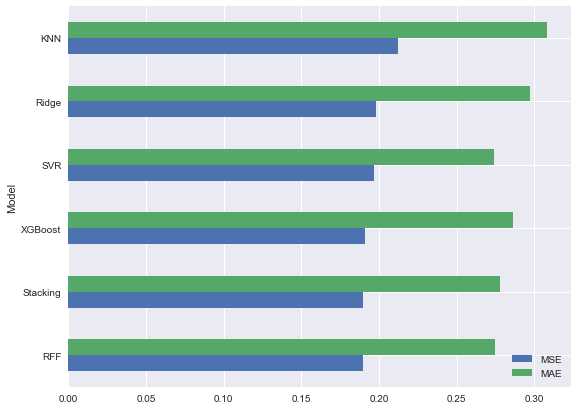

In [49]:
plt.style.use('seaborn')
final_results.reset_index().rename({'index': 'Model'}, axis=1).plot(x='Model', y=['MSE', 'MAE'], kind='barh', figsize=[9, 7]);

## Feature Importance

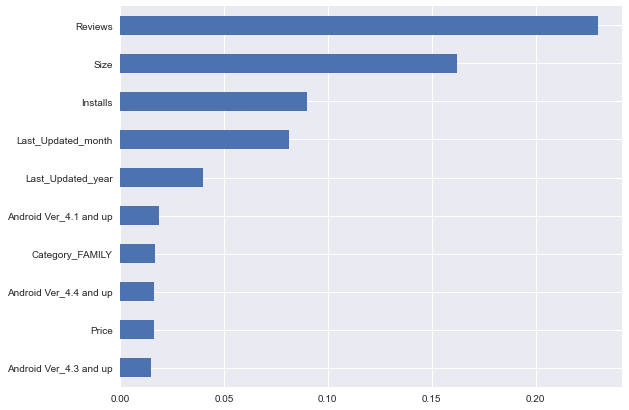

In [66]:
feat_importances = pd.Series(rff.feature_importances_, index=X_train.columns).sort_values().nlargest(10)
feat_importances.sort_values().plot(kind='barh', figsize=[9, 7]);